<a href="https://colab.research.google.com/github/jrsansom110515/team2_w25_milestone2_datafiles/blob/main/team2_w25_milestone2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier

import warnings

In [2]:
"""Clone the git repository that holds the CSV files"""
!git clone https://github.com/jrsansom110515/team2_w25_milestone2_datafiles.git

Cloning into 'team2_w25_milestone2_datafiles'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 21 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 2.06 MiB | 4.48 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
""" This cell contains key functions used throughout the remaining workbook"""

# Function to load in datasets

def load_data_csv(files_list):
    if len(files_list) != 2:
        raise ValueError("files_list must contain exactly two file names.")

    # Replace the file path with your location.
    MLB_df = pd.read_csv('/content/team2_w25_milestone2_datafiles/' + files_list[1])
    MiLB_df = pd.read_csv('/content/team2_w25_milestone2_datafiles/' + files_list[0])

    return MiLB_df, MLB_df


# Function to merge datasets and create a new column from the playerID to signify MLB debut

def merge_datasets(MiLB_df, MLB_df):
    MiLB_df['PlayerId'] = MiLB_df['PlayerId'].astype(str)
    MLB_df['PlayerId'] = MLB_df['PlayerId'].astype(str)

    merged_df = MiLB_df.merge(MLB_df[['PlayerId']], on = 'PlayerId', how = 'left', indicator = True)

    merged_df['MLB_debut'] = merged_df['_merge'].apply(lambda x: 1 if x == 'both' else 0)

    merged_df = merged_df.drop(columns=['PlayerId', '_merge', 'Name', 'Team'])

    return merged_df


# Function to extract age and level

def age_level(MiLB_m_df):

    # Get max age
    MiLB_m_df['max_age'] = MiLB_m_df['Age'].apply(lambda x: x.split('-')[1]).astype(int)

    # Get levels into dummy variables
    dummy_df = MiLB_m_df['Level'].str.get_dummies(',')
    dummy_df['num_level'] = dummy_df.sum(axis = 1)
    MiLB_m_df = pd.concat([MiLB_m_df,dummy_df], axis=1)
    MiLB_m_df = MiLB_m_df.drop(columns=['Level', 'Age'])

    return MiLB_m_df


# Function combine two datasets for train_test_split

def combine_dataset(df1, df2):
  combine_df_NA = pd.concat([df1, df2], axis = 0).reset_index(drop = True)
  combine_df = combine_df_NA.dropna(axis = 1)

  return combine_df


# Function to define features for X and y and to create a custom split of 0 and 1 in the target variable, the return is the train and test variables

def custom_training_testing(df, target_feature, train_size_0, train_size_1):
  """
    Parameters:
    df (pd.DataFrame): The dataset.
    target_feature (str): The name of the target column.
    train_size_0 (float): Proportion of class 0 to keep in training.
    train_size_1 (float): Proportion of class 1 to keep in training.
  """
  no_mlb_debut_0 = df[df[target_feature] == 0]
  yes_mlb_debut_1 = df[df[target_feature] == 1]

  df_0_train, df_0_test = train_test_split(no_mlb_debut_0, train_size = train_size_0, random_state = 42)
  df_1_train, df_1_test = train_test_split(yes_mlb_debut_1, train_size = train_size_1, random_state = 42)

  df_train = pd.concat([df_0_train, df_1_train]).sample(frac = 1, random_state = 42)
  df_test = pd.concat([df_0_test, df_1_test]).sample(frac = 1, random_state = 42)

  X_train, y_train = df_train.drop(columns = [target_feature]), df_train[target_feature]
  X_test, y_test = df_test.drop(columns = [target_feature]), df_test[target_feature]

  return X_train, X_test, y_train, y_test


# Function to define features for X and y to setup and perform testing with custom test size and parameters, the return is the train and test variables

def standard_training_testing(df, target_feature, test_size):
  X = df.drop(columns = [target_feature])
  y = df[target_feature]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 42, stratify = y)

  return X_train, X_test, y_train, y_test


# Function to Groupby matrix to see which levels have the most MLB debuts in the dataset

def levels_mlb_debut(df):
  levels = ['A-', 'A', 'A+', 'AA', 'AAA', 'R']

  ratios = {}

  for level in levels:
    num_with_mlb_debut = df[(df[level] == 1) & (df['MLB_debut'] == 1)].shape[0]
    total_level_count = df[df[level] == 1].shape[0]

    ratio = num_with_mlb_debut / total_level_count if total_level_count != 0 else 0

    ratios[level] = round(ratio, 2)

  return ratios

In [4]:
"""
Datasets that contains all MiLB batter data and datasets for MLB debut

These datasets names are the same as the ones previously shared, so these lists should be fine
as long as the names are not changed.
"""
milb_18_20, mlb_21_22 = load_data_csv(['Historical_MiLB_players_dataset_2018_2020.csv', 'MLB_debut_2021_2022.csv'])
milb_19_21, mlb_22_23 = load_data_csv(['Historical_MiLB_players_dataset_2019_2021.csv', 'MLB_debut_2022_2023.csv'])
milb_20_22, mlb_23_24 = load_data_csv(['Historical_MiLB_players_dataset_2020_2022.csv', 'MLB_debut_2023_2024.csv'])

In [5]:
milb_18_20.head()

,Name,Team,Level,Age,PA,BB%,K%,BB/K,AVG,OBP,...,OPS,ISO,Spd,BABIP,wSB,wRC,wRAA,wOBA,wRC+,PlayerId
0,Christian Bethancourt,MIL,AAA,26-26,418,0.047847,0.181818,0.263158,0.296675,0.327751,...,0.834145,0.209719,3.856732,0.318937,0.664623,61.600626,7.035243,0.358492,112.893234,10028
1,Tomas Telis,MIA,AAA,27-28,633,0.056872,0.099526,0.571429,0.319728,0.360759,...,0.806338,0.125850,3.715513,0.340426,-0.261360,90.123040,5.657395,0.349854,106.467915,10067
2,Nick Franklin,MIL,"A+,AA,AAA,R",27-28,416,0.125000,0.185096,0.675325,0.257062,0.351807,...,0.775536,0.166667,5.337587,0.296703,-0.062833,56.880421,0.111199,0.342564,101.249987,10166
3,Francisco Arcia,LAA,"AA,AAA",28-29,432,0.050926,0.162037,0.314286,0.232737,0.287059,...,0.588849,0.069054,3.268657,0.271875,-1.108097,29.449425,-29.670384,0.267188,52.290427,10286
4,Danny Ortiz,PHI,AAA,28-28,418,0.045455,0.241627,0.188119,0.232143,0.270335,...,0.668294,0.165816,1.629498,0.271429,-0.482535,39.405764,-7.674912,0.295148,83.698381,10317


In [6]:
"""
Merged datasets creating a new column of MLB debut with a 1 if player made debut in these years or 0 if they did not

Change the age column and level from a categorical variable to a numeric variable for modeling purposes
"""

# merge the above datasets
milb_18_20_mlb_21_22 = merge_datasets(milb_18_20, mlb_21_22)
milb_19_21_mlb_22_23 = merge_datasets(milb_19_21, mlb_22_23)
milb_20_22_mlb_23_24 = merge_datasets(milb_20_22, mlb_23_24)

# change the age and level columns to numeric
milb_18_20_mlb_21_22 = age_level(milb_18_20_mlb_21_22)
milb_19_21_mlb_22_23 = age_level(milb_19_21_mlb_22_23)
milb_20_22_mlb_23_24 = age_level(milb_20_22_mlb_23_24)


In [7]:
milb_20_22_mlb_23_24.head()

,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,...,wRC+,MLB_debut,max_age,A,A+,AA,AAA,CPX,DSL,num_level
0,766,0.073107,0.116188,0.629213,0.292264,0.350327,0.388252,0.738579,0.095989,3.220497,...,96.863135,0,31,0,0,0,1,0,0,1
1,407,0.110565,0.113022,0.978261,0.276056,0.358722,0.380282,0.739004,0.104225,4.243838,...,103.285626,0,29,0,0,0,1,0,0,1
2,581,0.201377,0.277108,0.726708,0.219298,0.375215,0.434211,0.809426,0.214912,3.606748,...,118.465065,0,30,0,0,0,1,0,0,1
3,350,0.122857,0.194286,0.632353,0.221854,0.328571,0.430464,0.759035,0.208609,2.678690,...,104.487300,0,28,0,0,0,1,0,0,1
4,534,0.104869,0.301498,0.347826,0.208238,0.343985,0.393593,0.737578,0.185355,2.294989,...,103.853435,0,32,0,0,1,1,0,0,2


In [8]:
"""Create the dataset for train_test_split to use on the datasets"""

tts_dataset = combine_dataset(milb_18_20_mlb_21_22, milb_19_21_mlb_22_23)


In [9]:
"""Groupby matrix to see which levels have the most MLB debuts in the dataset"""

level_ratio_df = levels_mlb_debut(tts_dataset)
level_ratio_df

{'A-': 0.04, 'A': 0.06, 'A+': 0.08, 'AA': 0.1, 'AAA': 0.09, 'R': 0.03}

In [10]:
"""Reduce the size of the dataset down to only players who have played at certain levels"""

tts_dataset_no_levels = tts_dataset.drop(columns=['A', 'A+', 'A-', 'R', 'AA', 'AAA'])

tts_dataset_no_levels.head(5)

,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,BABIP,wSB,wRC,wRAA,wOBA,wRC+,MLB_debut,max_age,num_level
0,418,0.047847,0.181818,0.263158,0.296675,0.327751,0.506394,0.834145,0.209719,3.856732,0.318937,0.664623,61.600626,7.035243,0.358492,112.893234,0,26,1
1,633,0.056872,0.099526,0.571429,0.319728,0.360759,0.445578,0.806338,0.125850,3.715513,0.340426,-0.261360,90.123040,5.657395,0.349854,106.467915,0,28,1
2,416,0.125000,0.185096,0.675325,0.257062,0.351807,0.423729,0.775536,0.166667,5.337587,0.296703,-0.062833,56.880421,0.111199,0.342564,101.249987,0,28,4
3,432,0.050926,0.162037,0.314286,0.232737,0.287059,0.301790,0.588849,0.069054,3.268657,0.271875,-1.108097,29.449425,-29.670384,0.267188,52.290427,0,29,2
4,418,0.045455,0.241627,0.188119,0.232143,0.270335,0.397959,0.668294,0.165816,1.629498,0.271429,-0.482535,39.405764,-7.674912,0.295148,83.698381,0,28,1


# Supervised Learning

In [50]:
"""
Run the function from the function list to return X_train, X_test, y_train, y_test

The function takes 4 inputs. 1 dataframe,
1 string name of the feature column that is the dependent variable,
a training size for did NOT make MLB debut (0) and training size for did make MLB debut (1)
"""

# Training weight for each class within the model
mlb_debut_yes = 0.75
mlb_debut_no = 0.50

X_train, X_test, y_train, y_test = custom_training_testing(tts_dataset_no_levels,'MLB_debut', mlb_debut_no, mlb_debut_yes)


""" Use models to start training and testing """

""" All features in this instance of the models """

print('-------------------------------------------------------------------------')

# Logistic Regression Classification
print("Logistic Regression Model (Probabilistic)")
lr_model = LogisticRegression(
                              penalty = 'l2',
                              class_weight = 'balanced',
                              max_iter = 10000,
                              random_state = 42
                              )

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

acc_test_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy on Split Test Set: {acc_test_lr:.2f}")
print("\nLogistic Regression Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_lr))

print('-------------------------------------------------------------------------')

# Extra Trees model
print("Extra Trees Model (Tree-Based)")
et_model = ExtraTreesClassifier(n_estimators = 1000, bootstrap = True, random_state = 42)

et_model.fit(X_train, y_train)

y_pred_et = et_model.predict(X_test)

acc_test_et = accuracy_score(y_test, y_pred_et)
print(f"Extra Trees Accuracy on Split Test Set: {acc_test_et:.2f}")
print("\nExtra Trees Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_et))

print('-------------------------------------------------------------------------')

# kNN Classifier Model
print("k-Nearest Neighbor Model (Instance-Based)")

#weighted kNN classifier with model parameter tuning
scores = []
k = range(1,10+1)

for i in k:
  knn = KNeighborsClassifier(n_neighbors = i, weights='distance')
  knn.fit(X_train, y_train)
  scores.append(knn.score(X_test, y_test))

k_best = k[int(np.argsort(scores)[-1])]


knn_model = KNeighborsClassifier(n_neighbors = k_best, weights='distance')

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

acc_test_knn = accuracy_score(y_test, y_pred_knn)
print("Optimal value of k: ", k_best)
print(f"k-Nearest Neighbor Accuracy on Split Test Set: {acc_test_knn:.2f}")
print("\nk-Nearest Neighbor Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_knn))

print('-------------------------------------------------------------------------')

-------------------------------------------------------------------------
Logistic Regression Model (Probabilistic)
Logistic Regression Accuracy on Split Test Set: 0.79

Logistic Regression Classification Report on Split Test Set:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      2528
           1       0.09      0.88      0.16        58

    accuracy                           0.79      2586
   macro avg       0.54      0.84      0.52      2586
weighted avg       0.98      0.79      0.87      2586

-------------------------------------------------------------------------
Extra Trees Model (Tree-Based)
Extra Trees Accuracy on Split Test Set: 0.98

Extra Trees Classification Report on Split Test Set:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2528
           1       0.00      0.00      0.00        58

    accuracy                           0.98      2586
   macro avg       0

In [51]:
""" Extract the most important features for Logistic Regression and Extra Trees model """

feature_importance_lr = pd.DataFrame({'Feature': X_train.columns, 'LR Importance': lr_model.coef_[0]})
feature_importance_et = pd.DataFrame({'Feature': X_train.columns, 'ET Importance': et_model.feature_importances_})

combined_importance = pd.merge(feature_importance_lr, feature_importance_et, on="Feature")

filtered_importance = combined_importance[(combined_importance['LR Importance'] > 0) & (combined_importance['ET Importance'] > 0)]

filtered_importance = filtered_importance.sort_values(by='LR Importance', ascending=False)

# Keep only the features that have a positive impact on both models
filtered_importance

,Feature,LR Importance,ET Importance
6,SLG,3.327674,0.052271
8,ISO,2.710986,0.051575
7,OPS,2.614673,0.048999
4,AVG,0.616687,0.050268
17,num_level,0.487498,0.057493
11,wSB,0.109069,0.051906
3,BB/K,0.090611,0.050638
15,wRC+,0.026992,0.050120
0,PA,0.005609,0.087956
12,wRC,0.000356,0.090896


In [52]:
# Select important features
less_features = filtered_importance['Feature'].tolist() + ['MLB_debut']
tts_dataset_less_features = tts_dataset.loc[:, less_features]

# Contains only the features in the less_features list
tts_dataset_less_features

,SLG,ISO,OPS,AVG,num_level,wSB,BB/K,wRC+,PA,wRC,MLB_debut
0,0.506394,0.209719,0.834145,0.296675,1,0.664623,0.263158,112.893234,418,61.600626,0
1,0.445578,0.125850,0.806338,0.319728,1,-0.261360,0.571429,106.467915,633,90.123040,0
2,0.423729,0.166667,0.775536,0.257062,4,-0.062833,0.675325,101.249987,416,56.880421,0
3,0.301790,0.069054,0.588849,0.232737,2,-1.108097,0.314286,52.290427,432,29.449425,0
4,0.397959,0.165816,0.668294,0.232143,1,-0.482535,0.188119,83.698381,418,39.405764,0
...,...,...,...,...,...,...,...,...,...,...,...
5282,0.381995,0.155718,0.690185,0.226277,2,-1.476500,0.475248,87.617538,465,55.381080,0
5283,0.309061,0.095469,0.583542,0.213592,3,-0.614987,0.230000,69.510016,674,55.477106,0
5284,0.395415,0.160458,0.727080,0.234957,2,1.600158,0.273273,102.109879,801,104.002204,0
5285,0.328872,0.107075,0.641059,0.221797,3,-2.476044,0.410405,83.334165,602,64.991860,0


In [53]:
"""
Run the function from the function list to return X_train, X_test, y_train, y_test

The function takes 4 inputs. 1 dataframe,
1 string name of the feature column that is the dependent variable,
a training size for did NOT make MLB debut (0) and training size for did make MLB debut (1)
"""

# This will retrain the models to use the new reduced amount of features based on the feature importance analysis

X_train, X_test, y_train, y_test = custom_training_testing(tts_dataset_less_features,'MLB_debut', mlb_debut_no, mlb_debut_yes)

""" Use models to start training and testing """

""" Reduced features in this instance of the models """

print('-------------------------------------------------------------------------')

# Logistic Regression Classification
print("Logistic Regression Model (Probabilistic)")
lr_model = LogisticRegression(
                              penalty = 'l2',
                              class_weight = 'balanced',
                              max_iter = 10000,
                              random_state = 42
                              )

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

acc_test_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy on Split Test Set: {acc_test_lr:.2f}")
print("\nLogistic Regression Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_lr))

print('-------------------------------------------------------------------------')

# Extra Trees model
print("Extra Trees Model (Tree-Based)")
et_model = ExtraTreesClassifier(n_estimators = 1000, bootstrap = True, random_state = 42)

et_model.fit(X_train, y_train)

y_pred_et = et_model.predict(X_test)

acc_test_et = accuracy_score(y_test, y_pred_et)
print(f"Extra Trees Accuracy on Split Test Set: {acc_test_et:.2f}")
print("\nExtra Trees Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_et))

print('-------------------------------------------------------------------------')

# kNN Classifier Model
print("k-Nearest Neighbor Model (Instance-Based)")

#weighted kNN classifier with model parameter tuning
scores = []
k = range(1,10+1)

for i in k:
  knn = KNeighborsClassifier(n_neighbors = i, weights='distance')
  knn.fit(X_train, y_train)
  scores.append(knn.score(X_test, y_test))

k_best = k[int(np.argsort(scores)[-1])]


knn_model = KNeighborsClassifier(n_neighbors = k_best, weights='distance')

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

acc_test_knn = accuracy_score(y_test, y_pred_knn)
print("Optimal value of k: ", k_best)
print(f"k-Nearest Neighbor Accuracy on Split Test Set: {acc_test_knn:.2f}")
print("\nk-Nearest Neighbor Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_knn))

print('-------------------------------------------------------------------------')

-------------------------------------------------------------------------
Logistic Regression Model (Probabilistic)
Logistic Regression Accuracy on Split Test Set: 0.78

Logistic Regression Classification Report on Split Test Set:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      2528
           1       0.08      0.88      0.15        58

    accuracy                           0.78      2586
   macro avg       0.54      0.83      0.51      2586
weighted avg       0.98      0.78      0.86      2586

-------------------------------------------------------------------------
Extra Trees Model (Tree-Based)
Extra Trees Accuracy on Split Test Set: 0.98

Extra Trees Classification Report on Split Test Set:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2528
           1       0.17      0.02      0.03        58

    accuracy                           0.98      2586
   macro avg       0

In [54]:
#confusion matrix
def plot_confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    labels = {"MLB No debut": 0, "MLB Yes debut": 1}.keys()
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display_cm.plot(colorbar=False)
    plt.title("Test Set Confusion Matrix")
    plt.show()

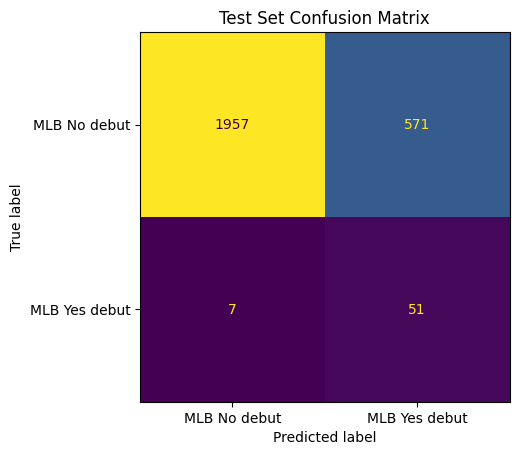

In [55]:
plot_confusion(y_test, y_pred_lr)

In [39]:
X_cv = tts_dataset_less_features.drop(columns=['MLB_debut'])
y_cv = tts_dataset_less_features['MLB_debut']

"""Compare evaluation metric between model families"""

#5-fold cross validation of the best model
cv_scores_lr = cross_val_score(lr_model, X_cv, y_cv, cv = 5, scoring = 'f1')
print("| Logistic Regression cross validation |")
print(f"Mean F1-score: {np.mean(cv_scores_lr):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_lr):.4f}")
print('-------------------------------------------------------------------------')

#5-fold cross validation of the 2nd best model
cv_scores_knn = cross_val_score(knn_model, X_cv, y_cv, cv = 5, scoring = 'f1')
print("| k-Nearest Neighbor cross validation |")
print(f"Mean F1-score: {np.mean(cv_scores_knn):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_knn):.4f}")
print('-------------------------------------------------------------------------')

#5-fold cross validation of the 3rd best model
cv_scores_et = cross_val_score(et_model, X_cv, y_cv, cv = 5, scoring = 'f1')
print("| Extra Trees cross validation |")
print(f"Mean F1-score: {np.mean(cv_scores_et):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_et):.4f}")

| Logistic Regression cross validation |
Mean F1-score: 0.2816
Standard Deviation: 0.1311
-------------------------------------------------------------------------
| k-Nearest Neighbor cross validation |
Mean F1-score: 0.0378
Standard Deviation: 0.0481
-------------------------------------------------------------------------
| Extra Trees cross validation |
Mean F1-score: 0.0158
Standard Deviation: 0.0194


In [40]:
auc=roc_auc_score(y_test, y_pred_lr)
print("Area under curve: ", auc)

Area under curve:  0.8267200458315146


In [41]:
#ROC-AUC curve
def plot_ROC(y_test, y_pred):
  fpr, tpr, thresholds = roc_curve(y_test,y_pred)

  plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
  plt.title('ROC curve')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.grid()
  plt.legend()
  plt.show()

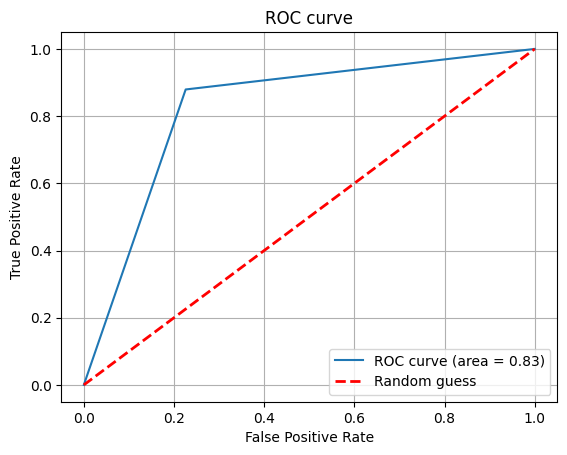

In [42]:
plot_ROC(y_test, y_pred_lr)

In [43]:
#Precision Recall curve
def plot_prc(X_test, y_test, y_pred, model):
  pr, re, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
  plt.plot(pr, re, linestyle='--', label='Precision Recall Curve')
  plt.xlabel('Precision')
  plt.ylabel('Recall')
  plt.legend()
  plt.show()

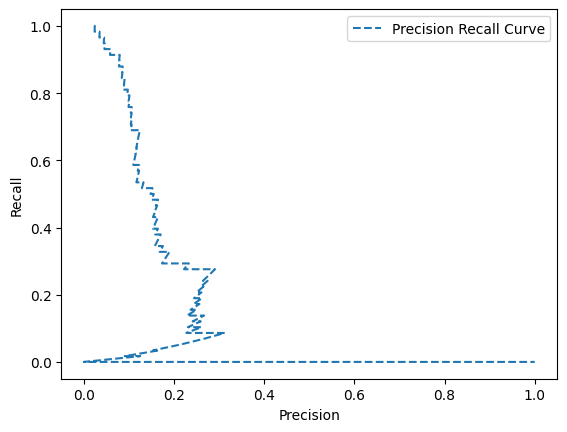

In [44]:
plot_prc(X_test,y_test,y_pred_lr,lr_model)

In [45]:
# Out of time validation

X_oot_new = milb_20_22_mlb_23_24.loc[:, [feature for feature in less_features if feature != 'MLB_debut']]
y_oot_new = milb_20_22_mlb_23_24['MLB_debut']

# Get predicted probabilities for the positive class (1)
y_probs_oot_new = lr_model.predict_proba(X_oot_new)[:, 1]

# Set a new threshold
threshold = 0.83
y_pred_oot_new = (y_probs_oot_new >= threshold).astype(int)


print(classification_report(y_oot_new, y_pred_oot_new))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2169
           1       0.41      0.58      0.48       109

    accuracy                           0.94      2278
   macro avg       0.70      0.77      0.72      2278
weighted avg       0.95      0.94      0.95      2278



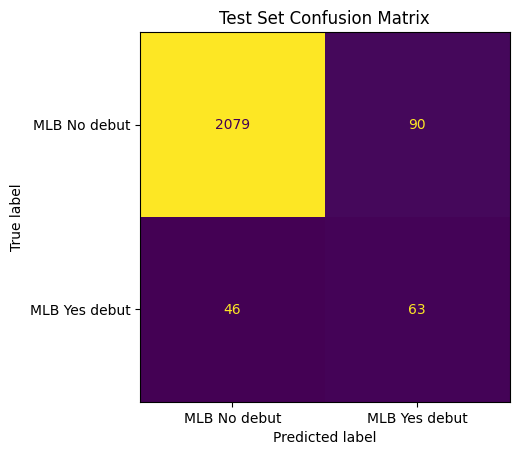

In [46]:
#Out of time validation confusion matrix
plot_confusion(y_oot_new, y_pred_oot_new)

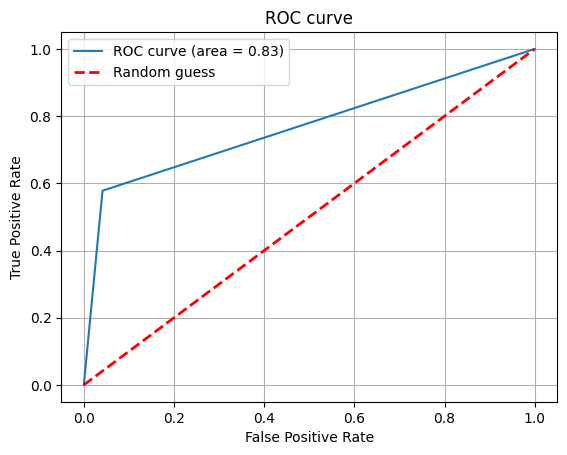

In [47]:
#ROC-AUC curve
plot_ROC(y_oot_new, y_pred_oot_new)

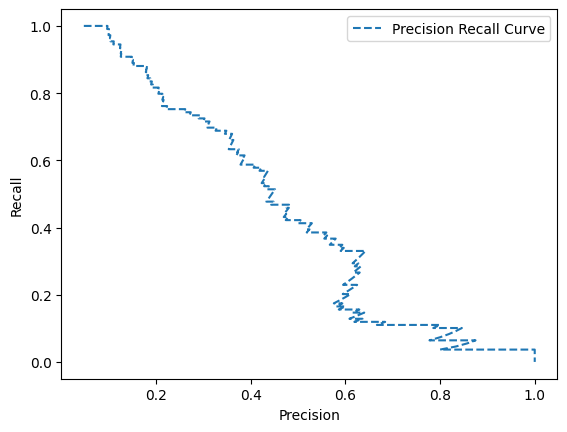

In [48]:
#Precision Recall curve
plot_prc(X_oot_new, y_oot_new, y_pred_oot_new, lr_model)

In [ ]:
# Predictions on who makes an MLB in 2025 or 2026
## Logistic Regression Model Used

#milb_22_24 = pd.read_csv('/content/team2_w25_milestone2_datafiles/Historical_MiLB_players_dataset_2022_2024.csv')

#future_mlb_full = age_level(milb_22_24)

# features = ['wRC', 'PA', 'wRC+', 'AVG', 'wRAA', 'max_age', 'wSB', 'BB/K', 'wOBA', 'SLG']
#features = ['wRC', 'wRC+', 'AVG', 'wSB', 'BB/K', 'SLG', 'ISO', 'OPS']
#future_mlb_less = future_mlb_full.loc[:, features]

#pred_fut_mlb = lr_model.predict(future_mlb_less)

#pred_fut_mlb
#%pip install shap

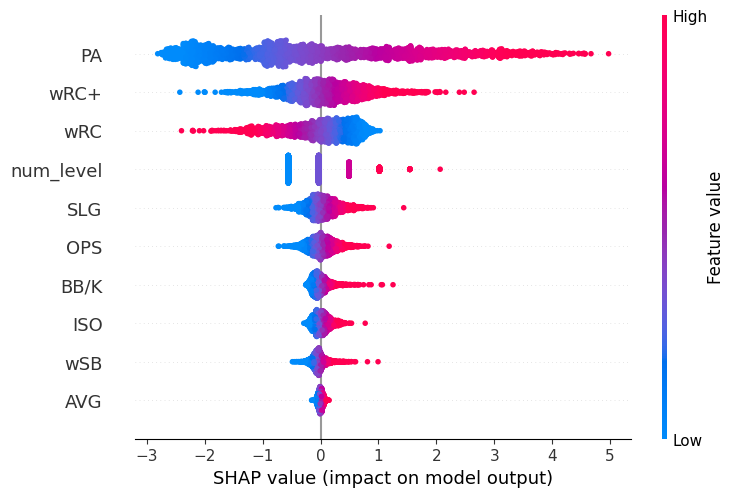

In [49]:
"""Feature importance analysis"""
import shap

explainer = shap.Explainer(lr_model, X_train, feature_names=['SLG','ISO','OPS','AVG','num_level','wSB','BB/K','wRC+','PA','wRC'])
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

In [ ]:
#Ablation analysis, remove PA from dataset
tts_dataset_noPA = tts_dataset_less_features[['SLG','ISO','OPS','AVG','num_level','wSB','BB/K','wRC+','wRC','MLB_debut']]

X_cv1 = tts_dataset_noPA.drop(columns=['MLB_debut'])
y_cv1 = tts_dataset_noPA['MLB_debut']

X_train, X_test, y_train, y_test = custom_training_testing(tts_dataset_noPA,'MLB_debut', mlb_debut_no, mlb_debut_yes)

lr_model_noPA = LogisticRegression(class_weight = 'balanced', max_iter = 10000, random_state = 42)
lr_model_noPA.fit(X_train, y_train)
y_pred_noPA = lr_model_noPA.predict(X_test)

#5-fold cross validation of the best model
cv_scores_lr = cross_val_score(lr_model_noPA, X_cv1, y_cv1, cv = 5, scoring = 'f1')
print("| Logistic Regression cross validation |")
print(f"Mean F1-score: {np.mean(cv_scores_lr):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_lr):.4f}")
print('-------------------------------------------------------------------------')

| Logistic Regression cross validation |
Mean F1-score: 0.2889
Standard Deviation: 0.1336
-------------------------------------------------------------------------


In [ ]:
#Ablation analysis, remove wRC+, wRC from dataset
tts_dataset_no_wRC = tts_dataset_less_features[['SLG','ISO','OPS','AVG','num_level','wSB','BB/K','PA','MLB_debut']]

X_cv2 = tts_dataset_no_wRC.drop(columns=['MLB_debut'])
y_cv2 = tts_dataset_no_wRC['MLB_debut']

X_train, X_test, y_train, y_test = custom_training_testing(tts_dataset_no_wRC,'MLB_debut', mlb_debut_no, mlb_debut_yes)

lr_model_no_wRC = LogisticRegression(class_weight = 'balanced', max_iter = 10000, random_state = 42)
lr_model_no_wRC.fit(X_train, y_train)
y_pred_no_wRC = lr_model_no_wRC.predict(X_test)

#5-fold cross validation of the best model
cv_scores_lr = cross_val_score(lr_model_no_wRC, X_cv2, y_cv2, cv = 5, scoring = 'f1')
print("| Logistic Regression cross validation |")
print(f"Mean F1-score: {np.mean(cv_scores_lr):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_lr):.4f}")
print('-------------------------------------------------------------------------')

| Logistic Regression cross validation |
Mean F1-score: 0.2884
Standard Deviation: 0.1329
-------------------------------------------------------------------------


In [ ]:
#Ablation analysis, remove num_level from dataset
tts_dataset_no_numlevel = tts_dataset_less_features[['SLG','ISO','OPS','AVG','wSB','BB/K','PA','wRC+','wRC','MLB_debut']]

X_cv3 = tts_dataset_no_numlevel.drop(columns=['MLB_debut'])
y_cv3 = tts_dataset_no_numlevel['MLB_debut']

X_train, X_test, y_train, y_test = custom_training_testing(tts_dataset_no_numlevel,'MLB_debut', mlb_debut_no, mlb_debut_yes)

lr_model_no_numlevel = LogisticRegression(class_weight = 'balanced', max_iter = 10000, random_state = 42)
lr_model_no_numlevel.fit(X_train, y_train)
y_pred_no_numlevel = lr_model_no_numlevel.predict(X_test)

#5-fold cross validation of the best model
cv_scores_lr = cross_val_score(lr_model_no_numlevel, X_cv3, y_cv3, cv = 5, scoring = 'f1')
print("| Logistic Regression cross validation |")
print(f"Mean F1-score: {np.mean(cv_scores_lr):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_lr):.4f}")
print('-------------------------------------------------------------------------')

| Logistic Regression cross validation |
Mean F1-score: 0.2752
Standard Deviation: 0.1156
-------------------------------------------------------------------------


In [ ]:
#Ablation analysis, remove SLG, OPS from dataset
tts_dataset_no_SLGOPS = tts_dataset_less_features[['ISO','AVG','num_level','wSB','BB/K','PA','wRC+','wRC','MLB_debut']]

X_cv4 = tts_dataset_no_SLGOPS.drop(columns=['MLB_debut'])
y_cv4 = tts_dataset_no_SLGOPS['MLB_debut']

X_train, X_test, y_train, y_test = custom_training_testing(tts_dataset_no_SLGOPS,'MLB_debut', mlb_debut_no, mlb_debut_yes)

lr_model_no_SLGOPS = LogisticRegression(class_weight = 'balanced', max_iter = 10000, random_state = 42)
lr_model_no_SLGOPS.fit(X_train, y_train)
y_pred_no_SLGOPS = lr_model_no_SLGOPS.predict(X_test)

#5-fold cross validation of the best model
cv_scores_lr = cross_val_score(lr_model_no_SLGOPS, X_cv4, y_cv4, cv = 5, scoring = 'f1')
print("| Logistic Regression cross validation |")
print(f"Mean F1-score: {np.mean(cv_scores_lr):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_lr):.4f}")
print('-------------------------------------------------------------------------')

| Logistic Regression cross validation |
Mean F1-score: 0.2871
Standard Deviation: 0.1374
-------------------------------------------------------------------------


In [ ]:
"""Sensitivity analysis"""
#Tune hyperparameters to observe the sensitivity of the F1 score
mlb_debut_yes = 0.75
mlb_debut_no = 0.50

X_train, X_test, y_train, y_test = custom_training_testing(tts_dataset_no_levels,'MLB_debut', mlb_debut_no, mlb_debut_yes)

X_cv = tts_dataset_less_features.drop(columns=['MLB_debut'])
y_cv = tts_dataset_less_features['MLB_debut']
#test class weight

def hyperparameter_tuning(df):
    iters = []
    results = []
    class_weights = ["balanced"]

    for max_iters in range(10000, 50000+1, 10000):

        lr_model = LogisticRegression(class_weight = 'balanced', max_iter = max_iters, random_state = 42)
        lr_model.fit(X_train, y_train)
        y_pred_lr = lr_model.predict(X_test)

        iters.append(max_iters)

        #5-fold cross validation of the best model
        cv_scores_lr = cross_val_score(lr_model, X_cv, y_cv, cv = 5, scoring = 'f1')
        print(f"Mean F1-score: {np.mean(cv_scores_lr):.4f}")
    results.append(cv_scores_lr)

    return iters,results

In [ ]:
df_MLB = tts_dataset_no_levels.drop(columns = ['MLB_debut'], errors = 'ignore')
lr_results = hyperparameter_tuning(df_MLB)

lr_results
#lr_results.sort_values(by='F1_score',ascending=False)

Mean F1-score: 0.2816
Mean F1-score: 0.2816
Mean F1-score: 0.2816
Mean F1-score: 0.2816
Mean F1-score: 0.2816


([10000, 20000, 30000, 40000, 50000],
 [array([0.17021277, 0.50666667, 0.16315789, 0.2173913 , 0.3507109 ])])

In [ ]:
"""Failure analysis"""
#Find edge cases, incorrect predictions

# Unsupervised Learning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import warnings
!git clone https://github.com/jrsansom110515/team2_w25_milestone2_datafiles.git

fatal: destination path 'team2_w25_milestone2_datafiles' already exists and is not an empty directory.


In [ ]:
# Function to load in datasets

def load_data_csv(files_list):

    # Replace the file path with your location.
    MiLB_df = pd.read_csv('/content/team2_w25_milestone2_datafiles/' + files_list)

    return MiLB_df

# Function to extract age and level

def age_level(MiLB_m_df):

    # Get max age
    MiLB_m_df['max_age'] = MiLB_m_df['Age'].apply(lambda x: x.split('-')[1]).astype(int)

    # Get levels into dummy variables
    dummy_df = MiLB_m_df['Level'].str.get_dummies(',')
    dummy_df['num_level'] = dummy_df.sum(axis = 1)
    MiLB_m_df = pd.concat([MiLB_m_df,dummy_df], axis=1)
    MiLB_m_df = MiLB_m_df.drop(columns=['Level', 'Age'])

    return MiLB_m_df

def normalize(X):
    return StandardScaler().fit_transform(X)

from itertools import product
def hyperparameter_tunning(milb,model, params):
    results = pd.DataFrame(list(product(*params.values())), columns=params.keys()) # create df for all combinations of parameters
    results[['silhouette_score','num_values','names']] = 0

    milb_dev = np.array(milb[['wRC', 'PA', 'wRC+', 'AVG', 'wRAA', 'max_age', 'wSB', 'BB/K', 'wOBA', 'SLG']])
    milb_norm = normalize(milb_dev)

    for index, row in results.iterrows():
        print(f"Running parameter combination {index+1}/{len(results)}")
        model.set_params(**results.loc[[index],params.keys()].to_dict(orient='records')[0])

        output = model.fit_predict(milb_norm)
        if 10 <= sum(output == -1) <= 25:
            results.loc[index,'silhouette_score'] = silhouette_score(milb_norm,output)
            results.loc[index,'num_values'] = sum(output == -1)
            results.loc[index,'names'] = ', '.join(milb.loc[output == -1,'Name'].tolist())

    return results

In [ ]:
milb = age_level(load_data_csv('Historical_MiLB_players_dataset_2022_2024.csv')) # Read file and format age/level
mlb_col = ['wRC', 'PA', 'wRC+', 'AVG', 'wRAA', 'max_age', 'wSB', 'BB/K', 'wOBA', 'SLG','AAA','AA','A+','A','CPX','DSL']

In [ ]:
# Normalize Data
milb_dev = np.array(milb[['wRC', 'PA', 'wRC+', 'AVG', 'wRAA', 'max_age', 'wSB', 'BB/K', 'wOBA', 'SLG','AAA','AA','A+','A','CPX','DSL']])

milb_norm = normalize(milb_dev)

In [ ]:
# DBSCAN First Path
milb['DBSCAN_label']  = DBSCAN(eps = 4).fit_predict(milb_norm)

milb[milb['DBSCAN_label'] == -1] # -1 are outliers

,Name,Team,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,...,PlayerId,max_age,A,A+,AA,AAA,CPX,DSL,num_level,DBSCAN_label
369,Michael Stefanic,LAA,1008,0.128968,0.071429,1.805556,0.349112,0.444334,0.455621,0.899955,...,25353,28,0,0,0,1,1,0,2,-1
2221,Chandler Simpson,TBR,1042,0.099808,0.087332,1.142857,0.325733,0.393792,0.374593,0.768385,...,sa3020219,23,1,1,1,0,1,0,4,-1


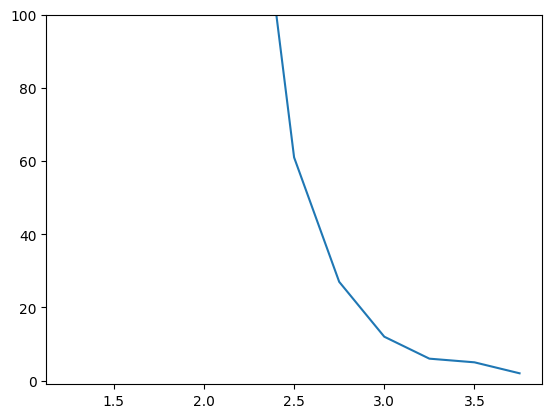

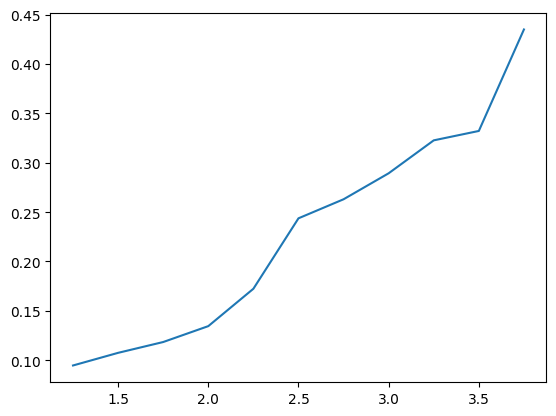

In [ ]:
# Run DBSCAN on multiple parameters to see how it changes
epsilons = [1.25,1.5,1.75,2,2.25,2.50,2.75,3,3.25,3.5,3.75]
num_out = []
sil_out = []

for eps in epsilons:
    milb['DBSCAN_label']  = DBSCAN(eps = eps).fit_predict(milb_norm)
    num_out.append(sum(milb['DBSCAN_label'] == -1))
    sil_out.append(silhouette_score(milb_norm, pd.to_numeric(milb['DBSCAN_label']==-1)))

# This shows high sensitivity to the choice of variables
plt.plot(epsilons,num_out)
plt.ylim([-1,100])
plt.show()

plt.plot(epsilons,sil_out)
plt.show()

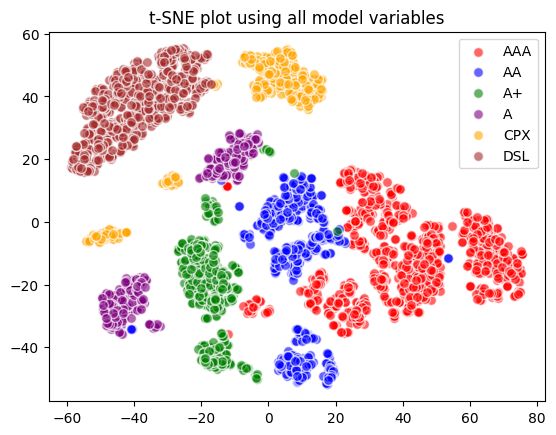

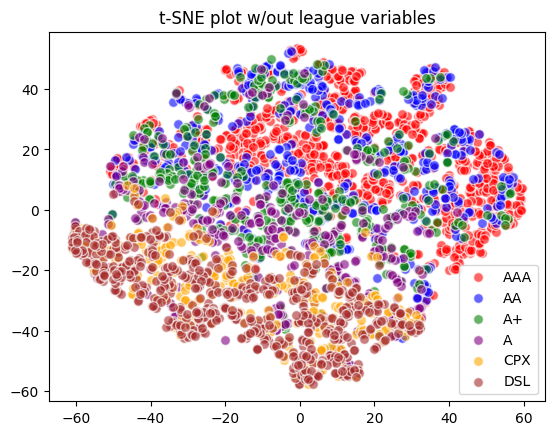

In [ ]:
# Visualizations using t-SNE
from sklearn.manifold import TSNE

best_league = milb[['AAA','AA','A+','A','CPX','DSL']].idxmax(axis=1) # Get Best league
# Create color mapping for graph
color_map = {category: idx for idx, category in enumerate(['AAA','AA','A+','A','CPX','DSL'])}
best_league_c = [color_map[cat] for cat in best_league]

colors = {
    'AAA': 'red',
    'AA': 'blue',
    'A+': 'green',
    'A': 'purple',
    'CPX': 'orange',
    'DSL': 'brown'
}

# Create t-SNE and plot graph
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(milb_norm)
for league, color in colors.items():
    indices = best_league == league
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=color, label=league, alpha=0.6, edgecolors='w', s=50)

#plt.scatter(X_tsne[:,0],X_tsne[:,1],c=colors, label = )
plt.title('t-SNE plot using all model variables')
plt.legend()
#plt.savefig('tSNE_overall.jpg')
plt.show()

# When using league data, the model naturally clusters individuals into each league
# One interesting insight is that we see some individuals who are not outliers to a cluster
# but an outlier to their own league. This could indicate a need to run this model on each league.

# Create t-SNE and plot graph w/out league in the data
cols = [m not in ['AAA','AA','A+','A','CPX','DSL'] for m in mlb_col]
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(milb_norm[:,cols])
for league, color in colors.items():
    indices = best_league == league
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=color, label=league, alpha=0.6, edgecolors='w', s=50)
plt.title('t-SNE plot w/out league variables')
plt.legend()
#plt.savefig('tSNE_overall_w_out_league.jpg')
plt.show()

# Despite the removal of league data, this indicate that the overall stats do tend to
# cluster around each league. Albeit with a lot more noise than before

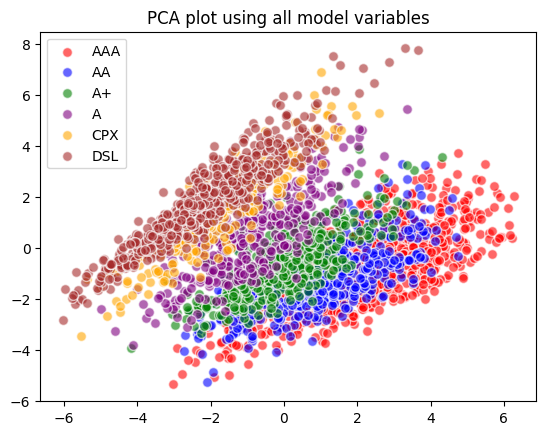

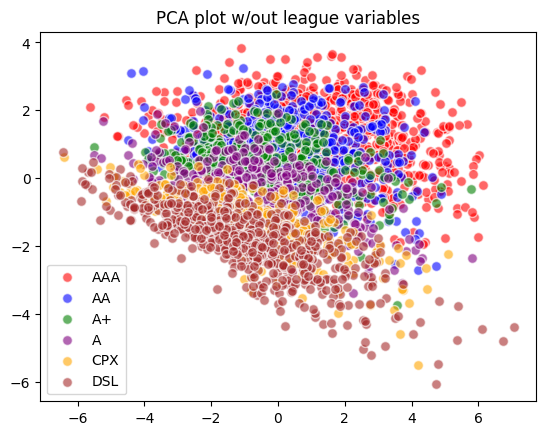

In [ ]:
#%%
from sklearn.decomposition import PCA

# Create PCA and plot graph
pca = PCA(n_components=2)
X_pca = pca.fit_transform(milb_norm)
for league, color in colors.items():
    indices = best_league == league
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=color, label=league, alpha=0.6, edgecolors='w', s=50)
plt.title('PCA plot using all model variables')
plt.legend()
#plt.savefig('PCA_overall.jpg')
plt.show()

# Crete PCA and plot graph w/out league in the data
cols = [m not in ['AAA','AA','A+','A','CPX','DSL'] for m in mlb_col]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(milb_norm[:,cols])
for league, color in colors.items():
    indices = best_league == league
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=color, label=league, alpha=0.6, edgecolors='w', s=50)
plt.title('PCA plot w/out league variables')
plt.legend()
#plt.savefig('PCA_overall_w_out_league.jpg')
plt.show()

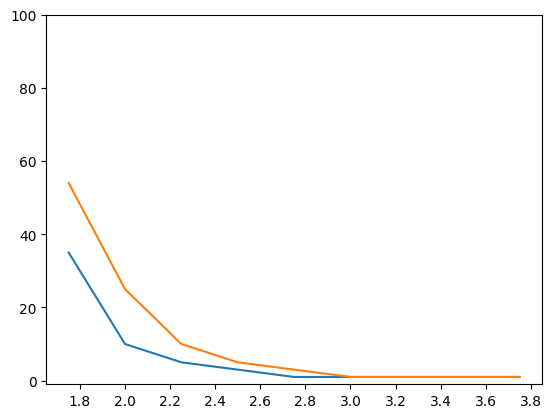

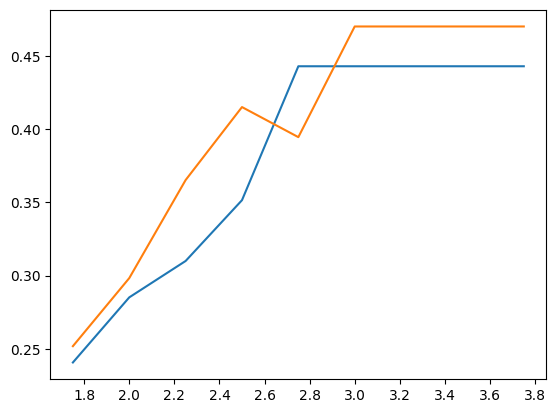

In [ ]:
warnings.filterwarnings("ignore")

# Re-Run for each league level
# Run DBSCAN on multiple parameters to see how it changes
epsilons = [1.75,2,2.25,2.50,2.75,3,3.25,3.40,3.5,3.6,3.75]
num_out = []
sil_out = []

for league in ['AAA','AA']:
    milb_l = milb.loc[best_league == league,]
    milb_dev_l = np.array(milb_l[['wRC', 'PA', 'wRC+', 'AVG', 'wRAA', 'max_age', 'wSB', 'BB/K', 'wOBA', 'SLG','AAA','AA','A+','A','CPX','DSL']])
    milb_norm_l = normalize(milb_dev_l)
    cols = [m not in ['AAA','AA','A+','A','CPX','DSL','PA'] for m in mlb_col]


    num_o = []
    sil_o = []
    for eps in epsilons:
        milb_l.loc[:,'DBSCAN_label']  = DBSCAN(eps = eps).fit_predict(milb_norm_l[:,cols])
        num_o.append(sum(milb_l['DBSCAN_label'] == -1))
        if (pd.to_numeric(milb_l['DBSCAN_label']==-1).nunique() == 1):
            sil_o.append(0)
        else:
            sil_o.append(silhouette_score(milb_norm_l, pd.to_numeric(milb_l['DBSCAN_label']==-1)))
    num_out.append(num_o)
    sil_out.append(sil_o)


# This again shows high sensitivity to the choice of variables
# It seems that 3.5 is that sweet spot of identify a few true outliers
for num_o in num_out:
    plt.plot(epsilons,num_o)
plt.ylim([-1,100])
plt.locator_params(axis='x', nbins=20)
plt.show()

for sil_o in sil_out:
    plt.plot(epsilons,sil_o)
plt.locator_params(axis='x', nbins=20)
plt.show()

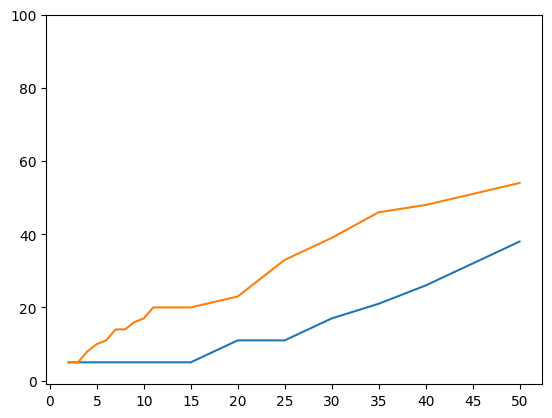

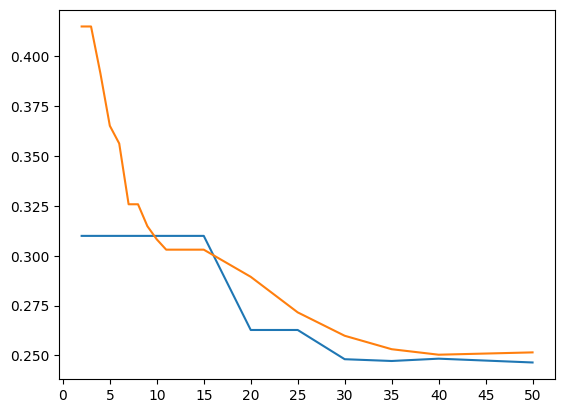

In [ ]:
warnings.filterwarnings("ignore")

# Re-Run for each league level
# Run DBSCAN on multiple parameters to see how it changes
min_samples = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,30,35,40,50]
num_out = []
sil_out = []

for league in ['AAA','AA']:
    milb_l = milb.loc[best_league == league,]
    milb_dev_l = np.array(milb_l[['wRC', 'PA', 'wRC+', 'AVG', 'wRAA', 'max_age', 'wSB', 'BB/K', 'wOBA', 'SLG','AAA','AA','A+','A','CPX','DSL']])
    milb_norm_l = normalize(milb_dev_l)
    cols = [m not in ['AAA','AA','A+','A','CPX','DSL','PA'] for m in mlb_col]


    num_o = []
    sil_o = []
    for sam in min_samples:
        milb_l.loc[:,'DBSCAN_label']  = DBSCAN(eps = 2.25, min_samples=sam).fit_predict(milb_norm_l[:,cols])
        num_o.append(sum(milb_l['DBSCAN_label'] == -1))
        sil_o.append(silhouette_score(milb_norm_l, pd.to_numeric(milb_l['DBSCAN_label']==-1)))
    num_out.append(num_o)
    sil_out.append(sil_o)

# This again shows high sensitivity to the choice of variables
# It seems that 3.5 is that sweet spot of identify a few true outliers
for num_o in num_out:
    plt.plot(min_samples,num_o)
plt.ylim([-1,100])
plt.locator_params(axis='x', nbins=20)
plt.show()

for sil_o in sil_out:
    plt.plot(min_samples,sil_o)
plt.locator_params(axis='x', nbins=20)
plt.show()

In [ ]:
# See results:
cols = [m not in ['AAA','AA','A+','A','CPX','DSL','PA'] for m in mlb_col]

for league in ['AAA','AA','A+','A','CPX','DSL']:
    milb_l = milb.loc[best_league == league,]
    milb_dev_l = np.array(milb_l[['wRC', 'PA', 'wRC+', 'AVG', 'wRAA', 'max_age', 'wSB', 'BB/K', 'wOBA', 'SLG','AAA','AA','A+','A','CPX','DSL']])
    milb_norm_l = normalize(milb_dev_l)

    milb_l['DBSCAN_label']  = DBSCAN(eps = 2.5).fit_predict(milb_norm_l)

    print(league)
    print(len(milb_l[milb_l['DBSCAN_label'] == -1]))
    print(milb_l[milb_l['DBSCAN_label'] == -1]['Name']) # -1 are outliers

AAA
62
56           Brandon Dixon
81              Greg Allen
85           Aramis Garcia
86              Derek Hill
110              Isan Diaz
               ...        
2631       Carson McCusker
2843          Payton Eeles
3083             Nick Dunn
3094    Cristopher Navarro
3099       Jonathan Guzman
Name: Name, Length: 62, dtype: object
AA
31
201          Ryan Aguilar
403           Nasim Nunez
536         Cody Milligan
580         Jeremy Arocho
588       Jeisson Rosario
686         Niko Decolati
696           Trey Harris
704        Chase Calabuig
744      Jeremiah Jackson
1009      Kaden Polcovich
1012      David Calabrese
1030            Arol Vera
1062     Sahid Valenzuela
1201         Victor Arias
1371          Luis Valdez
1579           Vaun Brown
1596         Braiden Ward
1644           Harry Ford
1732          Nelson Rada
1746       Fraymi De Leon
1786            Luis Baez
1825        Esteban Mejia
1851    Alfredo Velasquez
2100         Taylor Young
2160       Blake Rambusch
22

In [ ]:
# Focus on the AAA players
milb_AAA = milb.loc[best_league == 'AAA',].drop(columns = ['DBSCAN_label'], errors = 'ignore')
milb_dev_AAA = np.array(milb_AAA[['wRC', 'PA', 'wRC+', 'AVG', 'wRAA', 'max_age', 'wSB', 'BB/K', 'wOBA', 'SLG']])
milb_norm_AAA = normalize(milb_dev_AAA)

milb_AAA['DBSCAN_label']  = DBSCAN(eps = 2.25, min_samples=13).fit_predict(milb_norm_AAA)

print(len(milb_AAA[milb_AAA['DBSCAN_label'] == -1]))
print(milb_AAA[milb_AAA['DBSCAN_label'] == -1]) # -1 are outliers
silhouette_score(milb_norm_AAA, milb_AAA['DBSCAN_label'])

10
                  Name Team    PA       BB%        K%      BB/K       AVG  \
5          Elliot Soto  MIN   996  0.112450  0.248996  0.451613  0.221321   
28      Wynton Bernard  COL  1311  0.081617  0.163234  0.500000  0.308017   
173      Dairon Blanco  KCR   622  0.091640  0.213826  0.428571  0.315399   
223      Ernie Clement  CLE   407  0.078624  0.058968  1.333333  0.324251   
369   Michael Stefanic  LAA  1008  0.128968  0.071429  1.805556  0.349112   
427      Jonatan Clase  SEA  1520  0.128947  0.268421  0.480392  0.255994   
914      Tyler Tolbert  KCR  1643  0.086427  0.231284  0.373684  0.247911   
1484       Mike Antico  STL  1641  0.099939  0.226691  0.440860  0.258177   
1571      Caleb Durbin  ATL  1154  0.111785  0.093588  1.194444  0.269072   
2083      Jakob Marsee  SDP  1304  0.168712  0.197086  0.856031  0.236311   

           OBP       SLG       OPS  ...   PlayerId  max_age  A  A+  AA  AAA  \
5     0.314083  0.317497  0.631580  ...      11155       34  0   0   0

0.33680295812963595

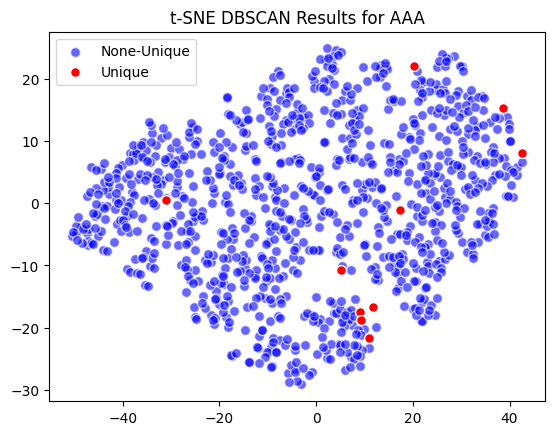

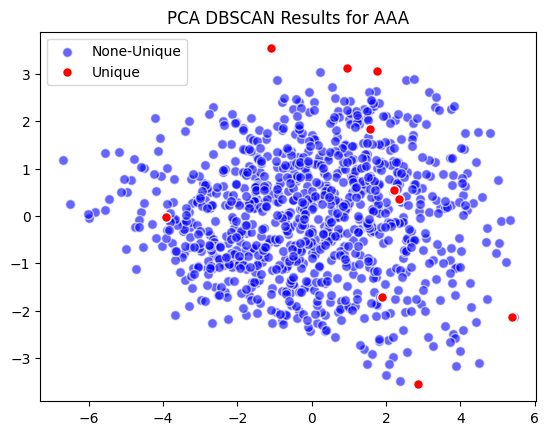

In [ ]:
# Create t-SNE and plot graph w/out league in the data
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(milb_norm_AAA)
plt.scatter(X_tsne[milb_AAA['DBSCAN_label'] != -1,0],X_tsne[milb_AAA['DBSCAN_label'] != -1,1], c = 'blue', label = 'None-Unique', alpha=0.6, edgecolors='w', s=50)
plt.scatter(X_tsne[milb_AAA['DBSCAN_label'] == -1,0],X_tsne[milb_AAA['DBSCAN_label'] == -1,1], c = 'red', label = 'Unique', alpha=1, edgecolors='w', s=50)
plt.title('t-SNE DBSCAN Results for AAA')
plt.legend()
#plt.savefig('tSNE_DBSCAN_Results_AAA.jpg')
plt.show()

# Crete PCA and plot graph w/out league in the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(milb_norm_AAA)
plt.scatter(X_pca[milb_AAA['DBSCAN_label'] != -1,0],X_pca[milb_AAA['DBSCAN_label'] != -1,1], label = 'None-Unique', c = 'blue', alpha=0.6, edgecolors='w', s=50)
plt.scatter(X_pca[milb_AAA['DBSCAN_label'] == -1,0],X_pca[milb_AAA['DBSCAN_label'] == -1,1], label = 'Unique', c = 'red', alpha=1, edgecolors='w', s=50)
plt.legend()
plt.title('PCA DBSCAN Results for AAA')
#plt.savefig('PCA_DBSCAN_Results_AAA.jpg')
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest

# Focus on the AAA players
milb_AAA = milb.loc[best_league == 'AAA',].drop(columns = ['DBSCAN_label'], errors = 'ignore')
milb_dev_AAA = np.array(milb_AAA[['wRC', 'PA', 'wRC+', 'AVG', 'wRAA', 'max_age', 'wSB', 'BB/K', 'wOBA', 'SLG']])
milb_norm_AAA = normalize(milb_dev_AAA)

milb_AAA['Isolation_label']  = IsolationForest(random_state = 42,contamination = 0.0095, n_estimators = 100, max_samples = 110, max_features = 5, bootstrap = False).fit_predict(milb_norm_AAA)

print(len(milb_AAA[milb_AAA['Isolation_label'] == -1]))

print(milb_AAA[milb_AAA['Isolation_label'] == -1]) # -1 are outliers
silhouette_score(milb_norm_AAA, milb_AAA['Isolation_label'])

10
                    Name Team    PA       BB%        K%      BB/K       AVG  \
264         Esteury Ruiz  SDP   635  0.119685  0.181102  0.660870  0.335922   
320      Chandler Seagle  SDP   633  0.066351  0.303318  0.218750  0.203866   
369     Michael Stefanic  LAA  1008  0.128968  0.071429  1.805556  0.349112   
399       Corbin Carroll  ARI   442  0.151584  0.242081  0.626168  0.306630   
512     Jackson Holliday  BAL  1017  0.197640  0.203540  0.971014  0.303594   
545      Anthony Mulrine  LAA   453  0.101545  0.253863  0.400000  0.175393   
2247     Taishi Nakawake  CHW   506  0.065217  0.282609  0.230769  0.194748   
2822   Kristian Campbell  BOS   601  0.139767  0.201331  0.694215  0.327309   
3094  Cristopher Navarro  COL   430  0.086047  0.237209  0.362745  0.190601   
3099     Jonathan Guzman  PHI   737  0.073270  0.260516  0.281250  0.183459   

           OBP       SLG       OPS  ...   PlayerId  max_age  A  A+  AA  AAA  \
264   0.444089  0.537864  0.981954  ...      217

0.39949324938624303

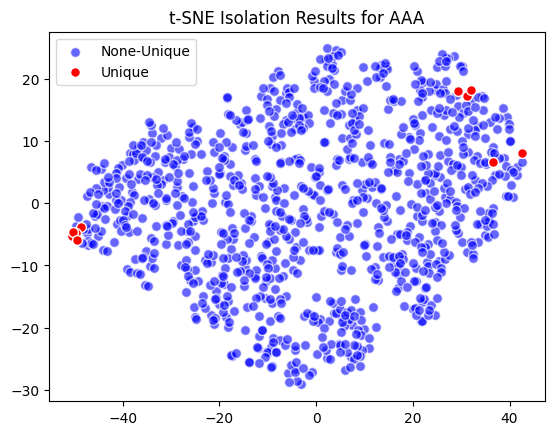

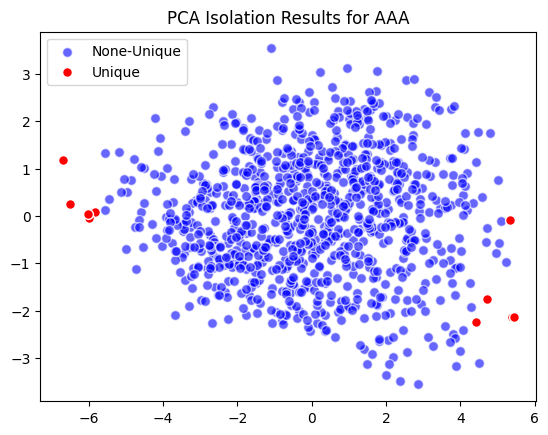

In [ ]:
# Create t-SNE and plot graph w/out league in the data
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(milb_norm_AAA)
plt.scatter(X_tsne[milb_AAA['Isolation_label'] != -1,0],X_tsne[milb_AAA['Isolation_label'] != -1,1], c = 'blue', label = 'None-Unique', alpha=0.6, edgecolors='w', s=50)
plt.scatter(X_tsne[milb_AAA['Isolation_label'] == -1,0],X_tsne[milb_AAA['Isolation_label'] == -1,1], c = 'red', label = 'Unique', alpha=1, edgecolors='w', s=50)
plt.title('t-SNE Isolation Results for AAA')
plt.legend()
#plt.savefig('tSNE_ISO_Results_AAA.jpg')
plt.show()

# Crete PCA and plot graph w/out league in the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(milb_norm_AAA)
plt.scatter(X_pca[milb_AAA['Isolation_label'] != -1,0],X_pca[milb_AAA['Isolation_label'] != -1,1], label = 'None-Unique', c = 'blue', alpha=0.6, edgecolors='w', s=50)
plt.scatter(X_pca[milb_AAA['Isolation_label'] == -1,0],X_pca[milb_AAA['Isolation_label'] == -1,1], label = 'Unique', c = 'red', alpha=1, edgecolors='w', s=50)
plt.legend()
plt.title('PCA Isolation Results for AAA')
#plt.savefig('PCA_ISO_Results_AAA.jpg')
plt.show()

In [ ]:
#### RUN hyperparameter TUNING FUNCTION! FOR AAA
milb_AAA = milb.loc[best_league == 'AAA',].drop(columns = ['DBSCAN_label'], errors = 'ignore')

params = {'eps':[1.5,1.75,2,2.1,2.2,2.25,2.3,2.4,2.5,2.75,3,3.25],
          'min_samples':list(map(int, [1,3,5,7,9,11,13,15,17,20]))}

dbscan_AAA_results = hyperparameter_tunning(milb_AAA,DBSCAN(), params)

#dbscan_AAA_results.to_csv('dbscan_AAA_results.csv')
dbscan_AAA_results.sort_values(by='silhouette_score',ascending=False)

Running parameter combination 1/120
Running parameter combination 2/120
Running parameter combination 3/120
Running parameter combination 4/120
Running parameter combination 5/120
Running parameter combination 6/120
Running parameter combination 7/120
Running parameter combination 8/120
Running parameter combination 9/120
Running parameter combination 10/120
Running parameter combination 11/120
Running parameter combination 12/120
Running parameter combination 13/120
Running parameter combination 14/120
Running parameter combination 15/120
Running parameter combination 16/120
Running parameter combination 17/120
Running parameter combination 18/120
Running parameter combination 19/120
Running parameter combination 20/120
Running parameter combination 21/120
Running parameter combination 22/120
Running parameter combination 23/120
Running parameter combination 24/120
Running parameter combination 25/120
Running parameter combination 26/120
Running parameter combination 27/120
Running pa

,eps,min_samples,silhouette_score,num_values,names
56,2.25,13,0.336803,10,"Elliot Soto, Wynton Bernard, Dairon Blanco, Er..."
21,2.00,3,0.333760,13,"Elliot Soto, Drew Maggi, Dairon Blanco, Ernie ..."
69,2.30,20,0.332080,12,"Elliot Soto, Wynton Bernard, Dairon Blanco, Er..."
78,2.40,17,0.331616,10,"Elliot Soto, Wynton Bernard, Dairon Blanco, Er..."
67,2.30,15,0.331616,10,"Elliot Soto, Wynton Bernard, Dairon Blanco, Er..."
...,...,...,...,...,...
41,2.20,3,0.000000,0,0
40,2.20,1,0.000000,0,0
39,2.10,20,0.000000,0,0
33,2.10,7,0.000000,0,0


In [ ]:
#### RUN hyperparameter TUNING FUNCTION! FOR AAA ---
milb_AAA = milb.loc[best_league == 'AAA',].drop(columns = ['DBSCAN_label'], errors = 'ignore')

params = {'n_estimators': list(range(50, 150, 10)),
          'max_samples': list(range(50, 150, 10)),
          'contamination': [0.008,0.009,0.0095,0.01,0.0105,0.011,0.012],
          'max_features': [4,5,6,7],
          'bootstrap': [True, False],
          'n_jobs': [5]}

#### This takes a fat minute to run
#isolation_AAA_results = hyperparameter_tunning(milb_AAA,IsolationForest(random_state = 42), params)

#isolation_AAA_results.to_csv('isolation_AAA_results.csv')
#isolation_AAA_results.sort_values(by='silhouette_score',ascending=False)

Running parameter combination 1/5600
Running parameter combination 2/5600
Running parameter combination 3/5600
Running parameter combination 4/5600
Running parameter combination 5/5600


KeyboardInterrupt: 